<a href="https://colab.research.google.com/github/ferbustamantes/AI_IB_VERANOS/blob/main/Proyecto_Final_Equipo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Producto Integrador de Aprendizaje
Red neuronal convolucional para predecir ciertos tipos de cáncer en Tomografías Computarizadas de pecho.
- - -
Fernando Bustamante Sandoval 1956646

Patricio López Solís 1947871

Roberto González Villarreal 1956324

---


**Se incluyen primeramente todas las librerias que son solicitadas dentro del programa**

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Pre-procesamiento de las imágenes


**Instalamos la biblioteca kaggle**

In [ ]:
!pip install kaggle

**Subimos el archivo kaggle.json que contiene las credenciales de la API de Kaggle, descargamos el set de datos y descomprimimos el archivo zip de set de datos**



In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robgv90","key":"cba6895bad2df430fcdcbe11c5bba12d"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 98% 116M/119M [00:04<00:00, 30.9MB/s]
100% 119M/119M [00:04<00:00, 26.8MB/s]


In [ ]:
!unzip /content/chest-ctscan-images.zip

Archive:  /content/chest-ctscan-images.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Data/test/adenocarcinoma/000117.png  
  inflating: Data/test/adenocarcin

**Ya teniendo las imagenes, se comienza con el preprocesamiento de las mismas**

In [ ]:

# Ruta de la carpeta principal de datos
data_folder = '/content/Data'

# Etiquetas correspondientes a las carpetas
labels = ['adeno', 'large', 'normal', 'squa']

# Arreglo para almacenar las imágenes
images = []
# Arreglo para almacenar las etiquetas
image_labels = []

# Recorremos las subcarpetas (train, val, test)
for folder in ['train','test']:
    # Recorremos las últimas carpetas (adeno, large, normal, squa)
    for label in labels:
        # Ruta de la carpeta actual
        folder_path = os.path.join(data_folder, folder, label)
        # Obtenemos la lista de archivos en la carpeta actual
        file_list = os.listdir(folder_path)

        # Recorremos los archivos de imagen en la carpeta actual
        for file_name in file_list:
            # Ruta completa de la imagen
            image_path = os.path.join(folder_path, file_name)
            # Cargamos la imagen utilizando OpenCV
            image = cv2.imread(image_path)

            # Si la imagen se cargó correctamente, la añadimos al arreglo images
            if image is not None:
                images.append(image)
                image_labels.append(label)

# Convertimos los arreglos en arrays de NumPy para mayor eficiencia
images = np.array(images)
image_labels = np.array(image_labels)



In [ ]:

# Definir rutas de entrenamiento, validación y prueba
train_path = '/content/Data/train'
test_path = '/content/Data/test'
val_path = '/content/Data/valid'

In [ ]:
# Función para obtener el número de imágenes en cada conjunto de datos
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Contar el número de archivos en la carpeta
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print('Train set:', train_set)
print('Validation set:', val_set)
print('Test set:', test_set)

Train set: {'.ipynb_checkpoints': 0, 'normal': 148, 'squa': 155, 'large': 115, 'adeno': 195}
Validation set: {'.ipynb_checkpoints': 0, 'normal': 13, 'squa': 15, 'large': 21, 'adeno': 23}
Test set: {'.ipynb_checkpoints': 0, 'normal': 54, 'squa': 90, 'large': 51, 'adeno': 120}


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Crear objeto para los datos de entrenamiento
train_data_augmentation = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)

train_data = train_data_augmentation.flow_from_directory(
    train_path,
    batch_size=5,
    target_size=(256, 256),
    class_mode='categorical'
)

# Crear objeto para los datos de test
test_data_augmentation = ImageDataGenerator(
    rescale=1.0/255.0
)

test_data = test_data_augmentation.flow_from_directory(
    test_path,
    batch_size=5,
    target_size=(256, 256),
    class_mode='categorical'
)

# Imprimir las clases encontradas en cada conjunto de datos
print("Clases encontradas en el conjunto de entrenamiento:", train_data.class_indices)
print("Clases encontradas en el conjunto de test:", test_data.class_indices)


Found 613 images belonging to 5 classes.
Found 315 images belonging to 5 classes.
Clases encontradas en el conjunto de entrenamiento: {'.ipynb_checkpoints': 0, 'adeno': 1, 'large': 2, 'normal': 3, 'squa': 4}
Clases encontradas en el conjunto de test: {'.ipynb_checkpoints': 0, 'adeno': 1, 'large': 2, 'normal': 3, 'squa': 4}


In [ ]:
# Saving class names
class_names = ['checkpoint','adeno', 'large', 'normal','squa', ]

In [ ]:

# Ruta de la carpeta principal de datos
data_folder = '/content/Data'

# Definir rutas de entrenamiento, validación y prueba
train_path = '/content/Data/train'
val_path = '/content/Data/valid'
test_path = '/content/Data/test'


# Aumentar el tamaño del conjunto de datos con técnicas de aumento de datos
train_data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)

val_data_augmentation = ImageDataGenerator(rescale=1.0 / 255.0)

test_data_augmentation = ImageDataGenerator(rescale=1.0 / 255.0)

train_data = train_data_augmentation.flow_from_directory(
    train_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

val_data = val_data_augmentation.flow_from_directory(
    val_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

test_data = test_data_augmentation.flow_from_directory(
    test_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)


Found 613 images belonging to 5 classes.
Found 72 images belonging to 5 classes.
Found 315 images belonging to 5 classes.


Notas de el pre-procesamiento:
*   La función ImageDataGenerator se implementó para reescalar las imágenes y
también para aplicar el aumento de datos en el subconjunto de entrenamiento.
*   La función flow_from_directory se implementó para redimensionar las imágenes a 256x256 píxeles.

# Creación de la arquitectura de la RNC

La red neuronal convolucional se basó en transferencia de aprendizaje. Se implementó la arquitectura InceptionResNetV2 proporcionada por Keras como la columna vertebral de la RNC, lo cual es una forma común de aplicar transferencia de aprendizaje en tareas de visión por computadora.

Agregamos el modelo pre-entrenado al modelo, y luego añadimos la capa superior para clasificar las imágenes. La capa final es una capa Dense con 4 neuronas porque hay 4 clases posibles. Implementamos la activación softmax para obtener la probabilidad de que la imagen pertenezca a cada una de las cuatro clases posibles.

Además, agregamos dos callbacks:

Model Checkpoint: para guardar por separado el mejor modelo hasta el momento en cada época.
Early Stopping: para detener el entrenamiento si la precisión no mejora más.

In [ ]:
# Definir el número de clases en tu conjunto de datos
num_classes = 5
# Utilizar una arquitectura diferente como VGG16
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Establecer las capas del modelo pre-entrenado como no entrenables
for layer in pretrained_model.layers:
    layer.trainable = False

# Crear el modelo secuencial
model = Sequential()

# Agregar el modelo pre-entrenado
model.add(pretrained_model)

# Sección de clasificación
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))  # Aumentar la tasa de Dropout para combatir el sobreajuste
model.add(Dense(len(class_names), activation='softmax'))

model.summary()

# Utilizar el optimizador Adam con una tasa de aprendizaje más alta
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Agregar el callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='/content/best_model_CNN.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Agregar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=11,
    verbose=1,
    mode='max',
    restore_best_weights=False
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              33555456  
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 48,275,269
Trainable params: 33,560,581
Non-trainable params: 14,714,688
_________________________________________________________________


En esta red neuronal se tiene una red profunda convolucional con diversas capas:


*   Capa convolucional de InceptionResNetV2 (modelo pre-entrenado): Definida por el modelo pre-entrenado InceptionResNetV2.

*   Capa Flatten: Transforma los mapas de características 3D en un vector unidimensional antes de pasarlos a las capas densas.
*   Capa Dense: Capa completamente conectada con 1024 neuronas y función de activación ReLU.

*   Capa Dropout: Aplica dropout con una tasa de 0.2, lo que ayuda a evitar el sobreajuste al desactivar aleatoriamente algunas neuronas durante el entrenamiento.


*   Capa Dense: Capa de salida con 4 neuronas (correspondientes a las 4 clases) y función de activación softmax, que genera probabilidades de pertenencia a cada clase.

En resumen, la red neuronal consta de al menos 4 capas, sin contar las capas internas del modelo pre-entrenado InceptionResNetV2. La cantidad exacta de capas en el modelo pre-entrenado depende de su arquitectura, pero en general, InceptionResNetV2 tiene múltiples capas convolucionales y capas de agrupación antes de la capa Flatten.

# Entrenamiento del modelo

In [ ]:

history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=20,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[checkpoint, early_stopping]
)



Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 8.1125 - accuracy: 0.3924 
Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to /content/best_model_CNN.hdf5
19/19 [==============================] - 554s 30s/step - loss: 8.1125 - accuracy: 0.3924 - val_loss: 5.9683 - val_accuracy: 0.4375
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 4.1300 - accuracy: 0.4974 
Epoch 2: val_accuracy did not improve from 0.43750
19/19 [==============================] - 552s 29s/step - loss: 4.1300 - accuracy: 0.4974 - val_loss: 5.8803 - val_accuracy: 0.3438
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 2.4362 - accuracy: 0.5577 
Epoch 3: val_accuracy improved from 0.43750 to 0.62500, saving model to /content/best_model_CNN.hdf5
19/19 [==============================] - 572s 30s/step - loss: 2.4362 - accuracy: 0.5577 - val_loss: 0.9779 - val_accuracy: 0.6250
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 1.44

# Resultados

Se obtienen los resultados comparando la efectividad y pérdida del test y se grafican estos mismos resultados a continuación.


In [ ]:
model.save('/content/CNN_model.h5')

# Cargar el modelo guardado

model = load_model('/content/CNN_model.h5')

# Evaluación del modelo
test_loss, test_acc = model.evaluate(test_data)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)



10/10 [==============================] - 258s 26s/step - loss: 0.7115 - accuracy: 0.6381
Test accuracy: 0.7180952596664429
Test loss: 0.7114906907081604


Text(0.5, 1.0, 'Training vs validation accuracy')

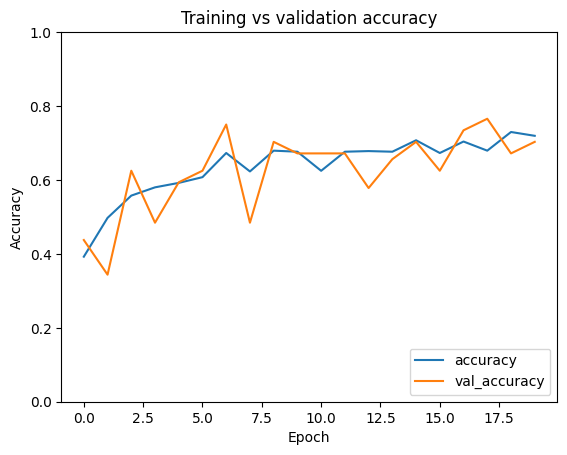

In [ ]:
# Graficar la precisión de entrenamiento vs. precisión de validación durante el entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation accuracy')



Text(0.5, 1.0, 'Training vs validation loss')

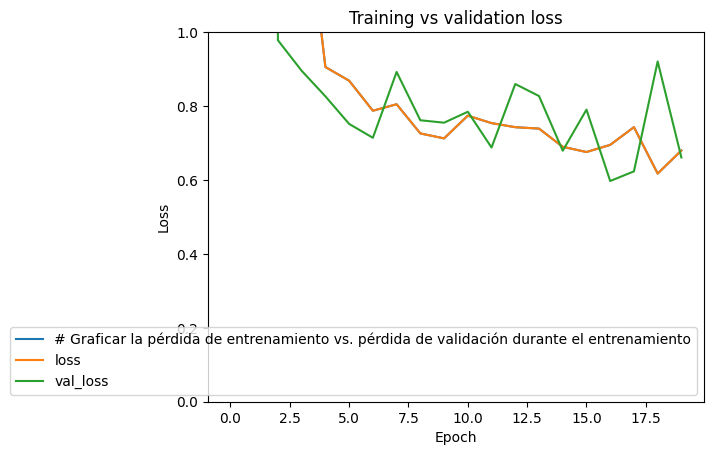

In [ ]:
# Graficar la pérdida de entrenamiento vs. pérdida de validación durante el entrenamiento
plt.plot(history.history['loss'], label='# Graficar la pérdida de entrenamiento vs. pérdida de validación durante el entrenamiento')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation loss')




10/10 [==============================] - 249s 25s/step - loss: 0.6606 - accuracy: 0.7175


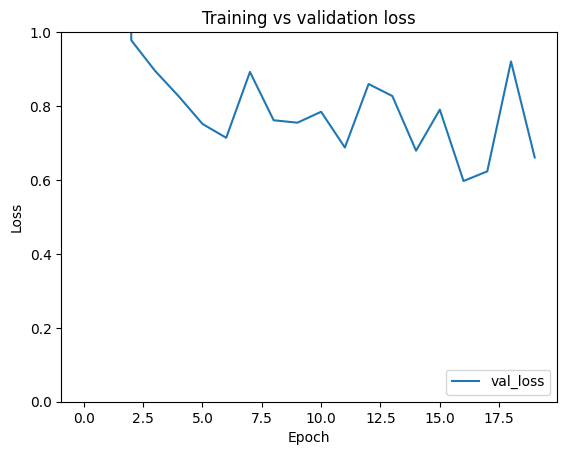

In [ ]:
# Cargar el modelo en el mejor punto de control
model_best = load_model('/content/best_model_CNN.hdf5')
test_loss, test_acc = model_best.evaluate(test_data)

plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation loss')

# Cargar el modelo en el mejor punto de control
model_best = load_model('/content/best_model_CNN.hdf5')
test_loss, test_acc = model_best.evaluate(test_data)

## Predicciones

En la fase de predicción, el modelo previamente entrenado se carga y se utiliza para realizar predicciones sobre nuevas imágenes. La función de predicción toma una imagen como entrada, la normaliza y la pasa al modelo para obtener las probabilidades de pertenencia a cada clase. La clase con mayor probabilidad se selecciona como la predicción del modelo. Luego, estas predicciones se comparan con las etiquetas reales para evaluar la precisión de la red neuronal en la clasificación de tipos de cáncer en Tomografías Computarizadas de pecho.

En este caso, se realizarán 10 predicciones.

In [ ]:
model = load_model('/content/CNN_model.h5')

In [ ]:
def prediction_fn(path, _model, classes_dir):
    # Cargar imagen
    img = image.load_img(path, target_size=(256,256))
    # Normalizar imagen
    norm_img = image.img_to_array(img) / 255.0
    # Convertir imagen a matriz numpy
    input_arr_img = np.array([norm_img])
    # Obtener predicciones
    pred = np.argmax(_model.predict(input_arr_img))
    # Devolver nombre de clase
    return classes_dir[pred]


In [ ]:
np.random.seed(3)

# Definir las clases disponibles
class_names = ['adeno', 'large', 'normal', 'squa']

# Vectores aleatorios que contienen rutas de imágenes para cada clase
largecell_vector = []
for i in range(2):
    path_largecell = '/content/Data/test/large'
    random_im = np.random.choice(os.listdir(path_largecell))
    largecell_vector.append(path_largecell + '/' + random_im)

adeno_vector = []
for i in range(3):
    path_adeno = '/content/Data/test/adeno'
    random_im = np.random.choice(os.listdir(path_adeno))
    adeno_vector.append(path_adeno + '/' + random_im)

normal_vector = []
for i in range(2):
    path_normal = '/content/Data/test/normal'
    random_im = np.random.choice(os.listdir(path_normal))
    normal_vector.append(path_normal + '/' + random_im)

sq_vector = []
for i in range(3):
    path_sq = '/content/Data/test/squa'
    random_im = np.random.choice(os.listdir(path_sq))
    sq_vector.append(path_sq + '/' + random_im)

1/1 [==============================] - 1s 955ms/step
Predicción de /content/Data/test/large/000113 (2).png 
La CNN predice large 
Y en realidad es large.cell.carcinoma



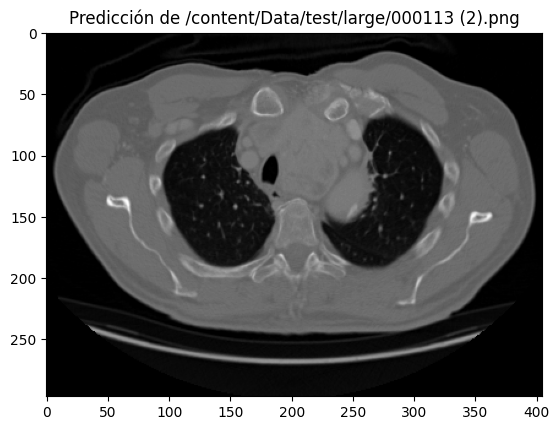

1/1 [==============================] - 1s 744ms/step
Predicción de /content/Data/test/large/000158.png 
La CNN predice large 
Y en realidad es large.cell.carcinoma



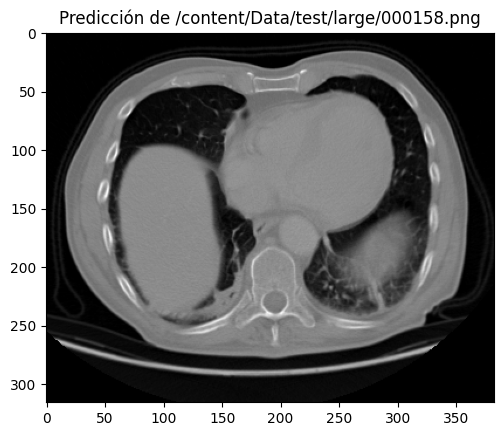

1/1 [==============================] - 1s 723ms/step
Predicción de /content/Data/test/squa/000144 (5).png 
La CNN predice squa 
Y en realidad es squamous.cell.carcinoma

1/1 [==============================] - 1s 746ms/step
Predicción de /content/Data/test/squa/000159 (5).png 
La CNN predice large 
Y en realidad es squamous.cell.carcinoma

1/1 [==============================] - 1s 721ms/step
Predicción de /content/Data/test/squa/000114 (2).png 
La CNN predice squa 
Y en realidad es squamous.cell.carcinoma

1/1 [==============================] - 1s 771ms/step
Predicción de /content/Data/test/adeno/000177 (4).png 
La CNN predice adeno 
Y en realidad es adenocarcinoma

1/1 [==============================] - 1s 1s/step
Predicción de /content/Data/test/adeno/000153 (5).png 
La CNN predice squa 
Y en realidad es adenocarcinoma

1/1 [==============================] - 1s 1s/step
Predicción de /content/Data/test/adeno/000137 (4).png 
La CNN predice adeno 
Y en realidad es adenocarcinoma

1/1 [==

In [ ]:
# Imprimir las 10 predicciones
for i in largecell_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es large.cell.carcinoma\n")
    test_im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    plt.imshow(test_im, cmap='gray')
    plt.title("Predicción de " + i)
    plt.show()

for i in sq_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es squamous.cell.carcinoma\n")

for i in adeno_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es adenocarcinoma\n")

for i in normal_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es normal\n")